In [2]:
import numpy as np
import pointprocesses as pp
import itertools
%matplotlib inline
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'pointprocesses'

In [2]:
plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams["figure.dpi"] = 100

In [3]:
%load_ext autoreload
%autoreload 2

The _likelihood function_ associated with a point process
$$\tilde N = {(t_i, \lambda_{t_i})}_i$$
with intensity parameterised by $\Theta\in\mathcal T$ is given by the probability of having $\tilde N$ under $\Theta$:
$$
\mathcal L(\Theta\,|\,\tilde N) = \mathbb P() = \exp\left(-\int_0^T \lambda(t)\,\mathrm dt \right)\prod_{i=1}^{N_T}\lambda(t_i)
$$

In [4]:
def mle_estimator(processes, tmax):
    process_sizes = np.array([len(p) for p in processes])
    return process_sizes.mean()/tmax

In [5]:
tmax = 20.0
lbda = 28
processes = [pp.poisson_process(tmax, lbda) for _ in range(1000)]

In [6]:
mle_estimator(processes, tmax)

28.006999999999998

In [7]:
single_proc = pp.poisson_process(tmax, lbda)
single_proc = single_proc.reshape((1, single_proc.shape[0]))
print(single_proc.shape)

(1, 540)


In [8]:
def pois_lik(data, lbda, tmax):
    """
    Log-likelihood implemented in Python.
    """
    n = data.shape[1]
    integral = -lbda*tmax
    rem = n*np.log(lbda)
    res = integral+rem
    return res

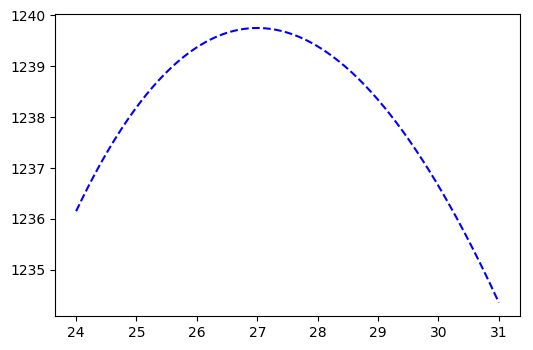

In [9]:
fig, ax = plt.subplots(figsize=(6,4))
xar = np.linspace(24,31,200)
yar_rust = [pp.likelihood.poisson_likelihood(single_proc, l, tmax) for l in xar]

ax.plot(xar, yar_rust, 'b--')

## Variable Poisson process

In [10]:
def intensity(x):
    return 5*(1- np.exp(-2*x))

In [11]:
close = np.array([0.,0.])
far = np.array([1.0,1.0])
lbda = 30.0

mdim_proc = pp.generalized.poisson_process(lbda, close, far)
mdim_proc.shape

(27, 2)

## Hawkes processes

A Hawkes process is a point process $N$ characterized by a stochastic intensity process with conditional:
\begin{align*}
\lambda(t\,|\,\mathcal H_t) &= \mu(t) + \sum_{t_i < t} g(t-t_i) \\
&= \mu(t) + \int g(t-s)\,\mathrm dN_s \\
&= \mu(t) + g * N_t
\end{align*}
where $g$ is a nonnegative function such that $g(t) = 0$ for all $t < 0$.

In [12]:
def kernel(t: float, decay: float):
    return np.exp(-decay*t)

def hawkes_intensity(t, lbda0, decay, evts):
    evts = evts[evts[:,0] < t]
    times = evts[:,0]
    jumps = evts[:,2]
    diff = t - times
    term = (jumps*kernel(diff, decay)).sum()
    return lbda0+term
hawkes_intensity = np.vectorize(hawkes_intensity, excluded={1,2,3})

In [13]:
def plot_hawkes(sample, tmax, lbda0, decay):
    fig, ax = plt.subplots(1, 1, figsize=(9,5))
    tarr = np.linspace(0, tmax, 800)
    intens_process = hawkes_intensity(tarr, lbda0, decay, sample)
    ax.plot(tarr, intens_process, linewidth=0.7)
    _, ymax = ax.get_ylim()
    ax.set_ylim((-0.1, ymax))
    ax.set_xlabel("Time $t$")
    ax.set_ylabel(r"Intensity $\lambda_t$")

In [80]:
alpha = 0.6
decay = 0.8
lbda0 = 1.4
tmax = 60.0
jumps = itertools.repeat(alpha)

We use our convenient Rust library for simulating the Hawkes process:

In [84]:
hawkes_sample = pp.hawkes_exp(tmax, decay, lbda0, jumps)
print("Event no. estimate:", tmax*lbda0/(1-alpha))
len(hawkes_sample)

Event no. estimate: 210.0


217

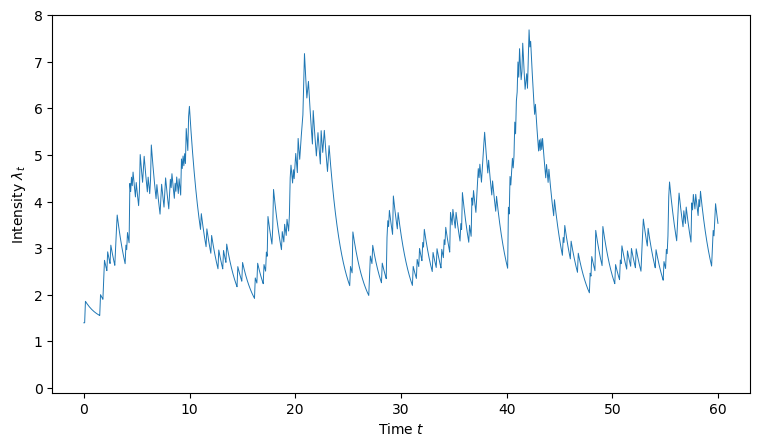

In [85]:
plot_hawkes(hawkes_sample, tmax, lbda0, decay)

In [17]:
import numpy as np
import numba as nb

We use the formula given in Ogata's 1981 paper to compute the log-likelihood: it is very computationally expensive.

We can use either `numba` or functions written in Rust to implement an algorithm to compute the result.

In [18]:
times = hawkes_sample[:, 0]

In [19]:
@nb.njit
def _A_func(times, t, decay):
    diff = t - times
    diff = diff[diff > 0]
    return np.sum(np.exp(-decay*diff))
_A_func = np.vectorize(_A_func, excluded={0})

@nb.njit
def _B_func(times, t, decay):
    diff = t - times
    diff = diff[diff > 0]
    return np.sum(diff*np.exp(-decay*diff))
_B_func = np.vectorize(_B_func, excluded={0})

@nb.njit
def _integral_term(times, mu, alpha, decay, tmax):
    diff = tmax - times
    res = mu*tmax + alpha*np.sum(1-np.exp(-decay*diff))
    return res

In [46]:
def hawkes_likelihood(arr, mu, alpha, decay, tmax):
    """
    Compute the log-likelihood of a Hawkes process given by `arr`.
    Args:
        arr[:,0] must be the event times
        tmax (float): temporal horizon
        mu: base event rate
        alpha (float): jump parameter
        decay (float): self-explanatory
    """
    times = arr[:,0]    
    integral = _integral_term(times, mu, alpha, decay, tmax)
    res = _A_func(times, times, decay)
    term2 = np.sum(np.log(mu + alpha*decay*res))
    res = -integral + term2
    return res

hawkes_likelihood = np.vectorize(hawkes_likelihood, excluded={0})

In [86]:
%%timeit
hawkes_likelihood(hawkes_sample, lbda0, alpha, decay, tmax)

2.31 ms ± 50.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [87]:
hawkes_likelihood(hawkes_sample, lbda0, alpha, decay, tmax)

array(69.90282315)

In [89]:
%%timeit
pp.likelihood.hawkes_likelihood(hawkes_sample, lbda0, alpha, decay, tmax)

501 µs ± 6.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [90]:
pp.likelihood.hawkes_likelihood(hawkes_sample, lbda0, alpha, decay, tmax)

70.22349867465357

The `numba` and Rust implementations of the likelihood function give just about the same results, and Rust is noticeably faster.

In [91]:
rust_hawkes_llhood = np.vectorize(
    pp.likelihood.hawkes_likelihood,
    excluded={0}
)

In [96]:
print("Real parameters:", (lbda0, alpha, decay))
min_alph = 0.3
max_alpha = 0.9
min_beta = 0.4
max_beta = 1.4
Ngrid = 50
X, Y = np.mgrid[min_alph:max_alpha:Ngrid*1j,min_beta:max_beta:Ngrid*1j]
Z = rust_hawkes_llhood(hawkes_sample, lbda0, X, Y, tmax)
print()
print(Z)

Real parameters: (1.4, 0.6, 0.8)

[[52.2515713  52.61144357 52.94574779 ... 56.83318053 56.8255246
  56.81647501]
 [53.47471097 53.83778572 54.17491316 ... 58.02909904 58.0195065
  58.0085081 ]
 [54.62948503 54.99539117 55.33499795 ... 59.15139081 59.13984569
  59.12688362]
 ...
 [61.40971899 61.72159415 62.00637226 ... 62.41700794 62.32243683
  62.22644456]
 [60.89930616 61.20806921 61.48989972 ... 61.81415764 61.71797637
  61.62037864]
 [60.3693915  60.675003   60.95385087 ... 61.19171961 61.0939385
  60.99474572]]


Text(0,0.5,'Likelihood $\\mathcal{L}(\\alpha, \\beta; X)$')

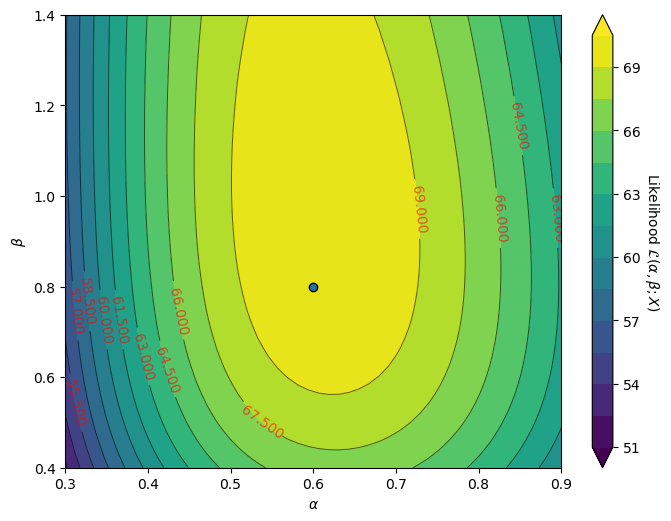

In [102]:
# Plot the log-likelihood in the (alpha, beta) plane

fig, ax = plt.subplots(1,1, figsize=(8,6), dpi=100)
extent = [min_alph, max_alpha, min_beta, max_beta]
#cax = ax.imshow(Z, interpolation='bilinear', origin='lower',
#                 extent=extent, aspect=1)
cs = ax.contour(
    X, Y, Z, 14,
    linewidths=0.7, colors='k',
    alpha=0.6)
csf = ax.contourf(
    X, Y, Z, 14,
    extend='both')
cs.clabel(colors='r')
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel(r"$\beta$")
ax.scatter(alpha, decay, edgecolors='k')
cbar = fig.colorbar(csf)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel(r"Likelihood $\mathcal{L}(\alpha, \beta; X)$", rotation=270)

We see the log-likelihood function is quite flat, meaning there will be trouble with a gradient descent algorithm's convergence.